In [4]:
import pandas as pd
import numpy as np
import pycountry
import re
import ast
import joblib
from computing_centroids import compute_centroids
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime
from gensim.test.utils import get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import country_converter as coco
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jahandelestangjim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Clean and prepare the data

In [79]:
data=pd.read_csv('un_general_debates_extended_cleaned.csv', index_col=0)
data['clean_text'] = data['clean_text'].apply(ast.literal_eval)
data

,country,text,year,country_name_short,UN_region,clean_text
0,CHL,i shall occupy this rostrum for a few minutes ...,1946,Chile,South America,"[shall, occupy, rostrum, minute, order, genera..."
1,COL,the colombian delegation does not consider it ...,1946,Colombia,South America,"[colombian_delegation, doe_consider, necessary..."
2,BLR,as more than a year has elapsed since the unit...,1946,Belarus,Eastern Europe,"[elapsed, united_charter, signed_francisco, po..."
3,IND,i stand before this great assembly unique in...,1946,India,Southern Asia,"[stand, great, unique_annals, human_history, r..."
4,GBR,"in his great pronouncement here the other day,...",1946,United Kingdom,Northern Europe,"[great, pronouncement, president_truman, used,..."
...,...,...,...,...,...,...
10563,GAB,"it is my pleasant duty to offer you, mr presi...",1963,Gabon,Middle Africa,"[pleasant_duty, offer, president_behalf, gabon..."
10564,TCD,"it is not without a certain pride, mixed with ...",1963,Chad,Middle Africa,"[certain, pride, mixed, speak_behalf, brings, ..."
10565,COL,"colombia, and the delegation which represents ...",1963,Colombia,South America,"[colombia, delegation, represents, particularl..."
10566,TUN,"mr president, it is a pleasure for me first o...",1963,Tunisia,Northern Africa,"[president, pleasure_offer, behalf_behalf, tun..."


In [80]:
def create_tag(row):
    country= row["country_name_short"].replace(' ', '_')
    if row["year"]<1990:
        time_stamp_cold_war='before'
    else:
        time_stamp_cold_war='after'
    return country + "_" + time_stamp_cold_war

data["tag"] = data.apply(lambda row: create_tag(row), axis=1)
data_backcup=data

## Group the data with tags

In [81]:
grouped_df=data.groupby('tag')['clean_text'].apply(sum).reset_index()
dict_tag_grouped_text = dict(zip(grouped_df['tag'], grouped_df['clean_text']))
data.loc[:,'clean_text_merged'] = data['tag'].map(lambda x: dict_tag_grouped_text.get(x, None))
data_year=data[['tag', 'clean_text_merged', 'country_name_short']]
data_year.drop_duplicates(subset=['tag'], keep='first', inplace=True)
data_year.reset_index(drop=True, inplace=True)

/tmp/ipykernel_16173/3940442243.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_df=data.groupby('tag')['clean_text'].apply(sum).reset_index()
/tmp/ipykernel_16173/3940442243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_year.drop_duplicates(subset=['tag'], keep='first', inplace=True)


In [82]:
data_before=data_year[data_year['tag'].str.endswith('before')]
data_after=data_year[data_year['tag'].str.endswith('after')]

## Average similarity of each word embedding with seed vector 

Here we first compute the centroids of each list of seed words, then of each speech, and look at the cosine similarity of each speech with the c_territorial and c_functional. Similar to Daniele 

### With Word2Vec

In [171]:
sub_data=data_after

In [172]:


sentences = sub_data['clean_text_merged'].values
model = Word2Vec(sentences, vector_size=200, min_count=1, window=20, sg=1)
fname = f"word2vec_period.model"
model.save(fname)

# Create an empty dictionary for word frequencies
word_freq = {}

# Count word frequencies
for sentence in sentences:
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1  # Increment count if the word is already in the dictionary
        else:
            word_freq[word] = 1  # Initialize count for new words

# Path to save the pickle file
pickle_file_path = 'wordscount_preprocess_period.pkl'

# Open the file in write-binary mode and save the dictionary
with open(pickle_file_path, 'wb') as f:
    pickle.dump(word_freq, f)

In [173]:
territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

fname = f"word2vec_period.model"

w2v = Word2Vec.load(fname)
words_frequency = joblib.load('wordscount_preprocess_period.pkl')

c_territorial=compute_centroids(w2v, territorial_terms, words_frequency)
c_functional=compute_centroids(w2v, functional_terms, words_frequency)

100%|██████████| 143132/143132 [00:00<00:00, 3173995.97it/s]


In [174]:
centroids=[]
for speech in sub_data['clean_text_merged'].values:
    speech_centroid= compute_centroids(w2v, speech, words_frequency)
    centroids.append(speech_centroid)
sub_data['speech_w2v_centroid']=centroids


100%|██████████| 143132/143132 [00:00<00:00, 3097373.47it/s]
/tmp/ipykernel_16173/1778395123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['speech_w2v_centroid']=centroids


## agglomerative and annex

/tmp/ipykernel_12364/1601702487.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['pca_w2v_embeddings']=sub_data.apply(lambda x: np.squeeze(x['speech_w2v_centroid']), axis=1)
/tmp/ipykernel_12364/1601702487.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['PCA_component1_w2v']=sub_data['tag'].map(pca_comp_1)
/tmp/ipykernel_12364/1601702487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Optimal number of clusters: 3
cluster  0  countries:  ['Estonia_after' 'United_Kingdom_after' 'Gambia_after' 'Uzbekistan_after'
 'Monaco_after' 'Cameroon_after' 'Austria_after' 'Iceland_after'
 'India_after' 'Burundi_after' 'Guinea-Bissau_after' 'Gabon_after'
 'Luxembourg_after' 'Chad_after' 'Namibia_after' 'Switzerland_after'
 'Romania_after' 'Netherlands_after' 'Senegal_after' 'Slovenia_after'
 'Zimbabwe_after' 'Sao_Tome_and_Principe_after' 'Haiti_after'
 'Niger_after' 'Bolivia_after' 'Andorra_after' 'Kazakhstan_after'
 'Mexico_after' 'Liechtenstein_after' 'Ireland_after' 'Czechia_after'
 'Lithuania_after' 'Mali_after' 'Zambia_after' 'Cabo_Verde_after'
 'Comoros_after' 'Canada_after' 'Singapore_after' 'Guatemala_after'
 'Thailand_after' 'Ecuador_after' 'Poland_after' 'Nepal_after'
 'Vatican_after' 'Laos_after' 'Chile_after' 'New_Zealand_after'
 'Central_African_Republic_after' 'Kyrgyz_Republic_after'
 'North_Macedonia_after' "Cote_d'Ivoire_after" 'Norway_after'
 'Tunisia_after' 'Ango

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

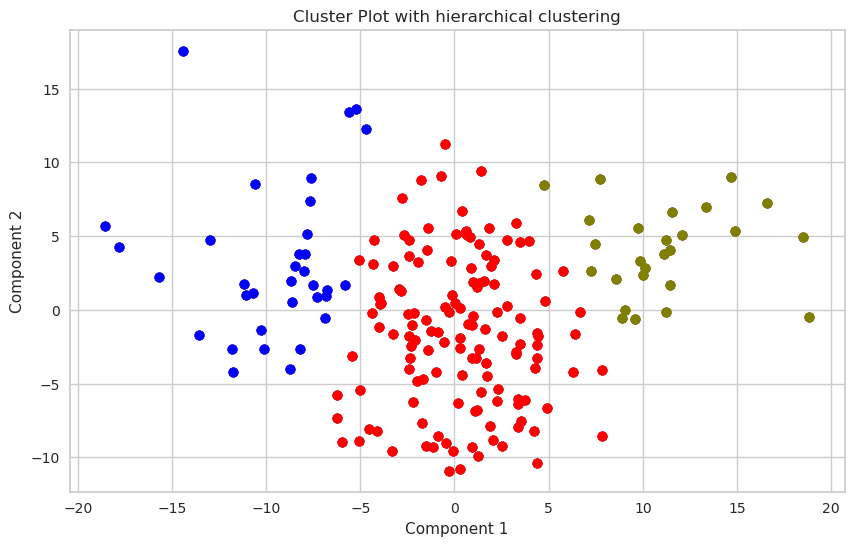

In [103]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

scaler = StandardScaler()
sub_data['pca_w2v_embeddings']=sub_data.apply(lambda x: np.squeeze(x['speech_w2v_centroid']), axis=1)


# Function to perform PCA
def perform_pca(data):
    # Convert the embeddings to a numpy array
    X = np.array(data['pca_w2v_embeddings'].tolist())
    
    # Standardize the data
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=2)
    #i keep 8 because 80% variance retained
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca

# Perform PCA on df_main
pca_main, X_pca_main = perform_pca(sub_data)

def project_pca(data_list):
    # X should be a numpy array of shape (n_samples, n_features)
    X_subset = np.array(data_list)
    
    # Step 2: Standardize the data
    X_scaled_subset = scaler.transform(X_subset)
    X_pca_subset = pca_main.transform(X_scaled_subset)

    return X_pca_subset

pca_comp_1={}
pca_comp_2={}

for year in set(sub_data['tag'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['tag']==year].reset_index()
    
    # Obtenir les projections 2D pour les embeddings de la famille actuelle
    projections_2D = project_pca(data['pca_w2v_embeddings'].tolist())
    pca_comp_1[year]=(projections_2D[:,0])
    pca_comp_2[year]=(projections_2D[:,1])  
    
sub_data['PCA_component1_w2v']=sub_data['tag'].map(pca_comp_1)
sub_data['PCA_component2_w2v']=sub_data['tag'].map(pca_comp_2)

X=np.stack(sub_data.apply(lambda row: (row['PCA_component1_w2v'][0], row['PCA_component2_w2v'][0]), axis=1).values)


from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Define a range of cluster numbers to try
min_clusters = 2
max_clusters = 10

# Initialize lists to store silhouette scores for each cluster number
silhouette_scores = []

# Iterate over the range of cluster numbers
for n_clusters in range(min_clusters, max_clusters + 1):
    # Fit hierarchical clustering model
    model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters based on the maximum silhouette score
optimal_n_clusters = np.argmax(silhouette_scores) + min_clusters

print(f'Optimal number of clusters: {optimal_n_clusters}')


hierarchical_cluster = AgglomerativeClustering(n_clusters=optimal_n_clusters, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(X)
sub_data['cluster']=labels

# Create COLOR_CLUSTERS dictionary
COLOR_CLUSTERS = {0: 'red', 1:'blue', 2:'olive', 3:'yellow', 4:'orange'}

fig, ax = plt.subplots(figsize=(10, 6))


for cluster in set(sub_data['cluster'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['cluster']==cluster].reset_index()
    print('cluster ', cluster, ' countries: ', data['tag'].values)
    ax.scatter(sub_data['PCA_component1_w2v'], sub_data['PCA_component2_w2v'], label=cluster, alpha=0.4, color=COLOR_CLUSTERS[cluster])

# Iterate over each row in the DataFrame
for index, row in sub_data.iterrows():
    # Extract x, y coordinates and cluster label
    x, y, cluster, tag = row['PCA_component1_w2v'], row['PCA_component2_w2v'], row['cluster'], row['tag']
    
    # Plot the point with color based on the cluster
    plt.scatter(x, y, c=COLOR_CLUSTERS[cluster], label=cluster)

# Add labels and legend
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Cluster Plot with hierarchical clustering')
# Show the plot
plt.show()

## k means

/tmp/ipykernel_16173/2758969342.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['pca_w2v_embeddings']=sub_data.apply(lambda x: np.squeeze(x['speech_w2v_centroid']), axis=1)
/tmp/ipykernel_16173/2758969342.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['PCA_component1_w2v']=sub_data['tag'].map(pca_comp_1)
/tmp/ipykernel_16173/2758969342.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Optimal number of clusters: 4
cluster  0  countries:  ['Estonia' 'United Kingdom' 'Monaco' 'Iceland' 'India' 'Switzerland'
 'Netherlands' 'Haiti' 'Bolivia' 'Andorra' 'Mexico' 'Ireland' 'Czechia'
 'Lithuania' 'Canada' 'Singapore' 'Guatemala' 'Ecuador' 'Poland' 'Vatican'
 'Chile' 'New Zealand' 'North Macedonia' 'Norway' 'Malaysia' 'France'
 'Belgium' 'Cuba' 'Croatia' 'Belarus' 'Honduras' 'Malta' 'Uruguay'
 'Sweden' 'Colombia' 'Brunei Darussalam' 'Indonesia' 'Peru' 'Spain'
 'Philippines' 'Nicaragua' 'Paraguay' 'Brazil' 'Timor-Leste' 'El Salvador'
 'Latvia' 'China' 'Ghana' 'Dominican Republic'
 'St. Vincent and the Grenadines' 'Italy' 'Costa Rica' 'Argentina'
 'Panama' 'Venezuela' 'Bangladesh' 'United States' 'Australia' 'Sri Lanka'
 'Germany']
cluster  1  countries:  ['Gambia' 'Uzbekistan' 'Cameroon' 'Austria' 'Burundi' 'Guinea-Bissau'
 'Gabon' 'Luxembourg' 'Chad' 'Namibia' 'Romania' 'Senegal' 'Slovenia'
 'Zimbabwe' 'Sao Tome and Principe' 'Niger' 'Kazakhstan' 'Liechtenstein'
 'Mali' 'Zam

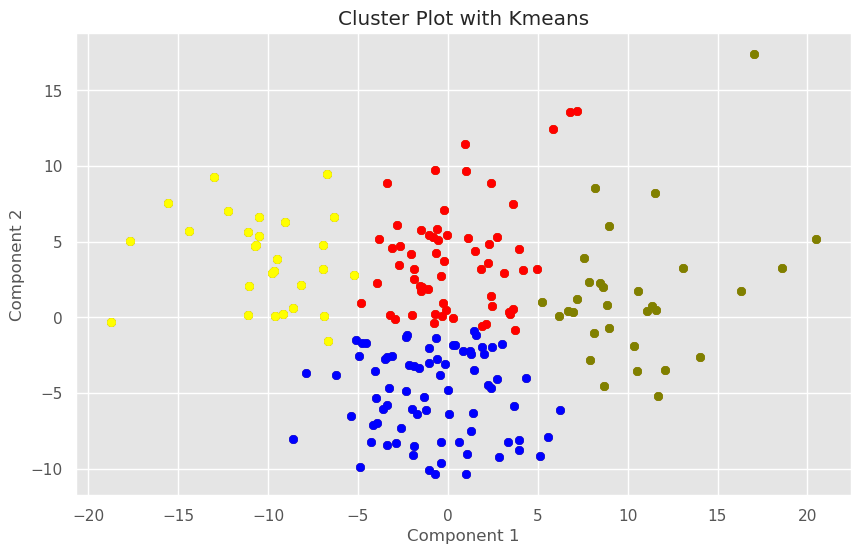

In [175]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
sub_data['pca_w2v_embeddings']=sub_data.apply(lambda x: np.squeeze(x['speech_w2v_centroid']), axis=1)


# Function to perform PCA
def perform_pca(data):
    # Convert the embeddings to a numpy array
    X = np.array(data['pca_w2v_embeddings'].tolist())
    
    # Standardize the data
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=2)
    #i keep 8 because 80% variance retained
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca

# Perform PCA on df_main
pca_main, X_pca_main = perform_pca(sub_data)

def project_pca(data_list):
    # X should be a numpy array of shape (n_samples, n_features)
    X_subset = np.array(data_list)
    
    # Step 2: Standardize the data
    X_scaled_subset = scaler.transform(X_subset)
    X_pca_subset = pca_main.transform(X_scaled_subset)

    return X_pca_subset

pca_comp_1={}
pca_comp_2={}

for year in set(sub_data['tag'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['tag']==year].reset_index()
    
    # Obtenir les projections 2D pour les embeddings de la famille actuelle
    projections_2D = project_pca(data['pca_w2v_embeddings'].tolist())
    pca_comp_1[year]=(projections_2D[:,0])
    pca_comp_2[year]=(projections_2D[:,1])  
    
sub_data['PCA_component1_w2v']=sub_data['tag'].map(pca_comp_1)
sub_data['PCA_component2_w2v']=sub_data['tag'].map(pca_comp_2)

X=np.stack(sub_data.apply(lambda row: (row['PCA_component1_w2v'][0], row['PCA_component2_w2v'][0]), axis=1).values)

# Define a range of cluster numbers to try
min_clusters = 2
max_clusters = 10

# Initialize lists to store silhouette scores for each cluster number
silhouette_scores = []

# Iterate over the range of cluster numbers
for n_clusters in range(min_clusters, max_clusters + 1):
    # Fit hierarchical clustering model
    model = KMeans(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters based on the maximum silhouette score
optimal_n_clusters = np.argmax(silhouette_scores) + min_clusters

print(f'Optimal number of clusters: {optimal_n_clusters}')


hierarchical_cluster = KMeans(n_clusters=optimal_n_clusters)
labels = hierarchical_cluster.fit_predict(X)
sub_data['cluster']=labels

# Create COLOR_CLUSTERS dictionary
COLOR_CLUSTERS = {0: 'red', 1:'blue', 2:'olive', 3:'yellow', 4:'orange'}

fig, ax = plt.subplots(figsize=(10, 6))


for cluster in set(sub_data['cluster'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['cluster']==cluster].reset_index()
    print('cluster ', cluster, ' countries: ', data['country_name_short'].values)
    ax.scatter(sub_data['PCA_component1_w2v'], sub_data['PCA_component2_w2v'], label=cluster, alpha=0.4, color=COLOR_CLUSTERS[cluster])

# Iterate over each row in the DataFrame
for index, row in sub_data.iterrows():
    # Extract x, y coordinates and cluster label
    x, y, cluster, tag = row['PCA_component1_w2v'], row['PCA_component2_w2v'], row['cluster'], row['country_name_short']
    
    # Plot the point with color based on the cluster
    plt.scatter(x, y, c=COLOR_CLUSTERS[cluster], label=cluster)

# Add labels and legend
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Cluster Plot with Kmeans')
# Show the plot
plt.show()

In [176]:
model = w2v
list_words=model.wv.index_to_key
list_word_embdeds=[model.wv[word] for word in list_words]
# Extract PCA component 1 scores for all words
word_pca_scores = project_pca(list_word_embdeds)[:, 0]

# Sort words based on PCA component 1 scores in descending order
sorted_word_indices = np.argsort(word_pca_scores)[::-1]
sorted_words = [list_words[i] for i in sorted_word_indices]

# Select top N words with highest PCA component 1 scores
top_n = 50
top_words = sorted_words[:top_n]
print("Top {} words with highest PCA component 1 scores:".format(top_n))
print(top_words)

Top 50 words with highest PCA component 1 scores:
['arab_territory', 'unconditional_withdrawal', 'occupied_territory', 'occupation', 'israel', 'syrian_golan', 'jerusalem', 'east_jerusalem', 'jerusalem_capital', 'annexation', 'territory_occupied', 'azerbaijan', 'acquisition_territory', 'international_legitimacy', 'lebanese_territory', 'lebanon', 'nagorno_karabakh', 'establish_independent', 'syria', 'israeli_force', 'palestinian_territory', 'occupied_arab', 'israeli', 'jew', 'occupation_territory', 'occupied_syrian', 'palestinian_people', 'hamas', 'annexation_kuwait', 'withdrawal_occupied', 'golan', 'israeli_occupation', 'violating', 'city_jerusalem', 'aggressor', 'syria_lebanon', 'quds_sharif', 'israel_continued', 'occupied', 'line_june', 'syrian_arab', 'aqsa_mosque', 'jewish', 'withdrawal_iraqi', 'border_june', 'palestinian', 'arab_land', 'just_comprehensive', 'occupation_arab', 'fait_accompli']


In [177]:
country_cluster_dict = dict(zip(sub_data['country_name_short'], sub_data['cluster']))

data_after_whole=data_backcup[['year', 'country_name_short', 'tag', 'clean_text']]
data_after_whole=data_after_whole[data_after_whole['year']>=1990]
data_after_whole['cluster']= data_after_whole['country_name_short'].map(country_cluster_dict)

In [178]:
data_after_whole.to_csv('data_with_clusters_post_1990.csv')

# Produce df for map

In [12]:
data_before_whole=pd.read_csv('data_year_country_with_w2v_centroids_backup.csv', index_col=0)

data_before_whole=data_before_whole[['country', 'year', 'clean_text_merged', 'territoriality_w2v_centroid', 'functionality_w2v_centroid', 'speech_w2v_centroid']]
data_before_whole['Period'] = pd.cut(data_before_whole['year'], bins=[float('-inf'), 1990, float('inf')], labels=['Before 1990', 'After 1990'])
data_before_whole['tag']=(data_before_whole['Period']).astype(str)+'_'+data_before_whole['country']
data_before_whole=data_before_whole[['country', 'year', 'speech_w2v_centroid', 'Period']]
data_before_whole

,country,year,speech_w2v_centroid,Period
0,CHL,1946,[[ 0.04409352 -0.07610565 0.07841529 -0.02286...,Before 1990
1,COL,1946,[[ 4.28368710e-02 -9.10701007e-02 7.81906098e...,Before 1990
2,BLR,1946,[[ 6.57470897e-02 -9.34881940e-02 9.17791948e...,Before 1990
3,IND,1946,[[ 0.08233076 -0.08206817 0.06648913 -0.04824...,Before 1990
4,GBR,1946,[[ 0.05362493 -0.07696427 0.06299604 -0.07086...,Before 1990
...,...,...,...,...
10563,GAB,1963,[[ 0.062194 -0.08208878 0.1025263 -0.02491...,Before 1990
10564,TCD,1963,[[ 0.0527666 -0.07852616 0.10093775 -0.03738...,Before 1990
10565,COL,1963,[[ 0.06234292 -0.08467675 0.09946557 -0.04926...,Before 1990
10566,TUN,1963,[[ 5.60665317e-02 -5.82756959e-02 9.74436328e...,Before 1990


In [6]:
fname = f"word2vec_whole_corpus_year_country.model"

w2v = Word2Vec.load(fname)
words_frequency = joblib.load('wordscount_preprocess.pkl')

In [11]:
territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

lex = [territorial_terms, functional_terms] 

def linear_projection_1D(pVec, vecXLeft, vecXRight):    
    vecX = vecXRight.mean(axis=0) - vecXLeft.mean(axis=0) 
    return np.dot(pVec, vecX)  

def get_vector(model, words, num_features=200): 
    words = [w for w in words if w in model.wv.index_to_key]
    L = len(words)
    temp = np.zeros((L, num_features))
    for i, x in enumerate(words):
        temp[i,:] = model.wv[x]
    return temp

def custom_projection_1D(z, model):
    M = model.vector_size
    x_terr, x_func = [get_vector(model, words, M) for words in lex] 
    projections = [linear_projection_1D(x, x_terr, x_func) for x in z]
    Z = np.array(projections) 
    return Z

In [13]:
df_sorted=data_before_whole
# Function to fix formatting by adding commas between numbers
def extract_numbers(s):
    # Find all numbers using regex
    numbers = re.findall(r'[-]?\d\.\d+', s)
    # Convert the extracted strings to floats
    return [float(num) for num in numbers]

# Apply the formatting fix
df_sorted['speech_w2v_centroid'] = df_sorted['speech_w2v_centroid'].apply(extract_numbers)


Text(0.5, 1.0, 'Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)')

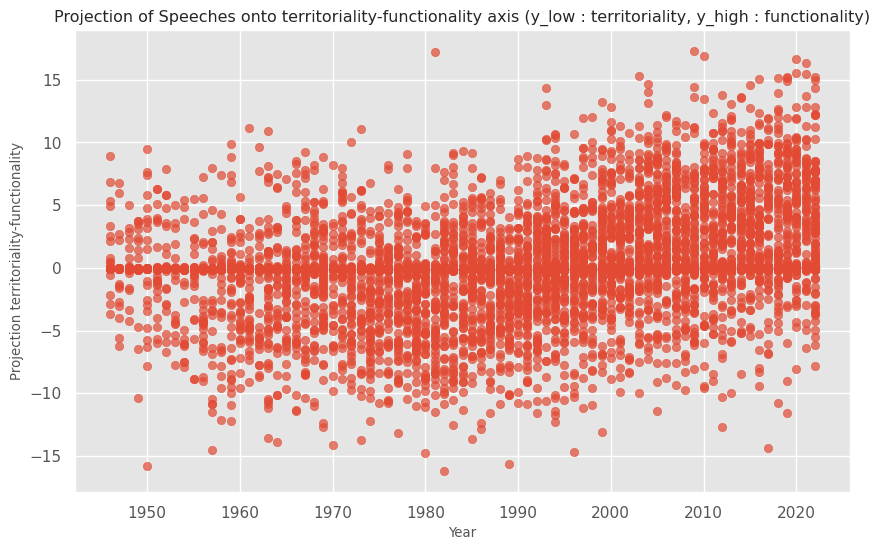

In [14]:
model=w2v

lex = [territorial_terms, functional_terms] 

# Définir la taille de la police de caractère
plt.rcParams.update({'font.size': 8})

# Trier les données par année
df_sorted = df_sorted.sort_values(by=['year'])

# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

projections_1D = custom_projection_1D(df_sorted['speech_w2v_centroid'].values, model)

# Créer un graphique en nuage de points pour la famille actuelle
ax.scatter(df_sorted['year'], projections_1D, alpha=0.7)

# Label the axes
plt.xlabel("Year")
plt.ylabel("Projection territoriality-functionality")
plt.title("Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)")

In [15]:
df_sorted['projection (above 0 is more functional, below is more territorial)']=projections_1D
# # Group the DataFrame by 'Country' and 'Period', and calculate the mean of column 'C'
df_grouped = df_sorted.groupby(['country', 'Period'])[['projection (above 0 is more functional, below is more territorial)']].mean().reset_index()
df_grouped.to_csv('data_terr_func_per_country_per_period.csv')

/tmp/ipykernel_8197/1872368684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_sorted.groupby(['country', 'Period'])[['projection (above 0 is more functional, below is more territorial)']].mean().reset_index()


/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


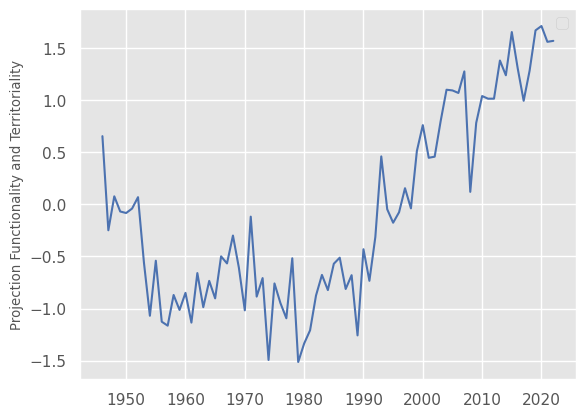

In [22]:
df_grouped = df_sorted.groupby(['year'])[['projection (above 0 is more functional, below is more territorial)']].mean().reset_index()

# Créer un graphique en nuage de points pour la famille actuelle
ax=sns.lineplot(data=df_grouped, x="year", y="projection (above 0 is more functional, below is more territorial)", color='b')

ax.set_ylabel('Projection Functionality and Territoriality')
ax.set_xlabel(None)

plt.legend()
# Display the plot
plt.show()


In [19]:
df_grouped

,year,"projection (above 0 is more functional, below is more territorial)"
0,1946,0.654863
1,1947,-0.248499
2,1948,0.077284
3,1949,-0.068246
4,1950,-0.082918
...,...,...
72,2018,1.283183
73,2019,1.670404
74,2020,1.712301
75,2021,1.560465


In [2]:
data_before_whole=pd.read_csv('data_with_clusters_post_1990.csv', index_col=0)
data_before_whole['clean_text'] = data_before_whole['clean_text'].apply(ast.literal_eval)

In [12]:
df_grouped.to_csv('data_terr_func_per_country_per_period.csv')

In [202]:
sub_data=data_before_whole[data_before_whole['cluster']==3]
grouped_df=sub_data.groupby('year')['clean_text'].apply(sum).reset_index()
dict_tag_grouped_text = dict(zip(grouped_df['year'], grouped_df['clean_text']))
sub_data.loc[:,'clean_text_merged'] = sub_data['year'].map(lambda x: dict_tag_grouped_text.get(x, None))
sub_data=sub_data[['year', 'clean_text_merged']]
sub_data.drop_duplicates(subset=['year'], keep='first', inplace=True)
sub_data.reset_index(drop=True, inplace=True)

/tmp/ipykernel_16173/428725112.py:2: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_df=sub_data.groupby('year')['clean_text'].apply(sum).reset_index()
/tmp/ipykernel_16173/428725112.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data.loc[:,'clean_text_merged'] = sub_data['year'].map(lambda x: dict_tag_grouped_text.get(x, None))


In [181]:
territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

fname = f"word2vec_period.model"


w2v = Word2Vec.load(fname)
words_frequency = joblib.load('wordscount_preprocess_period.pkl')

c_territorial=compute_centroids(w2v, territorial_terms, words_frequency)
c_functional=compute_centroids(w2v, functional_terms, words_frequency)

100%|██████████| 143132/143132 [00:00<00:00, 2905958.79it/s]


In [191]:
territoriality=[]
functionality=[]
centroids=[]
for speech in sub_data['clean_text_merged'].values:
    speech_centroid= compute_centroids(w2v, speech, words_frequency)
    similarity_territorial = cosine_similarity(speech_centroid, c_territorial)[0][0]
    similarity_functional= cosine_similarity(speech_centroid, c_functional)[0][0]

    territoriality.append(similarity_territorial)
    functionality.append(similarity_functional)
    centroids.append(speech_centroid)

100%|██████████| 143132/143132 [00:00<00:00, 3039491.68it/s]


In [183]:
sub_data['territoriality_w2v_centroid']=territoriality
sub_data['speech_w2v_centroid']=centroids
sub_data['functionality_w2v_centroid']=functionality

/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.

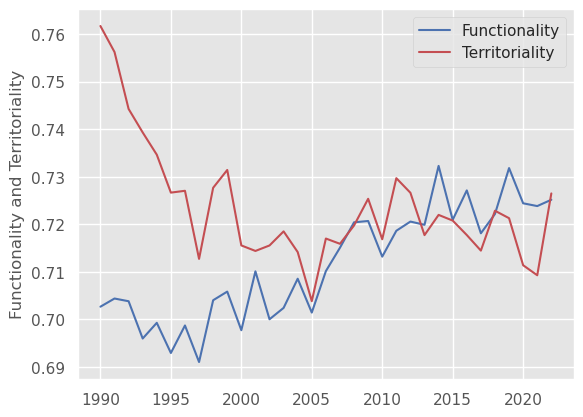

In [184]:
# # Add labels to the axes (optional)
ax=sns.lineplot(data=sub_data, x="year", y="functionality_w2v_centroid", label='Functionality', color='b')

sns.lineplot(data=sub_data, x="year", y="territoriality_w2v_centroid", color='r', label='Territoriality')
ax.set_ylabel('Functionality and Territoriality')
ax.set_xlabel(None)

plt.legend()
# Display the plot
plt.show()

In [205]:

from sklearn.metrics import pairwise_distances

# Assuming words_array is your array with each element being a list of words
corpus_words = set(word for sublist in sub_data['clean_text_merged'].values for word in sublist)

model=w2v

list_words=model.wv.index_to_key
list_word_embdeds=[model.wv[word] for word in list_words]
corpus_words=[word for word in list_words if word in corpus_words]
corpus_vectors=[model.wv[word] for word in corpus_words]

distances = pairwise_distances(c_functional, corpus_vectors, metric='cosine')
ind = [np.argpartition(i, 50)[:50] for i in distances][0]
closest = [corpus_words[indexes] for indexes in ind]
print('top 50 words closest to functional centroid : ', closest)

top 50 words closest to functional centroid :  ['emulation', 'alarmist', 'corner_earth', 'exclusivity', 'conspire', 'cohesion_society', 'heritage_culture', 'regime_trample', 'social_marginalization', 'stratum_society', 'exploitative', 'opportunist', 'paternalism', 'take_root', 'serve_fertile', 'dustbin_history', 'advantage_offered', 'disenchanted', 'instils', 'institution_founded', 'extremist_idea', 'hinders_effort', 'inequality_oppression', 'lead_wider', 'total_absolute', 'political_affiliation', 'unequal_access', 'empire_building', 'attack_root', 'perfected', 'applying_rule', 'laboriously', 'imbalance_exist', 'religious_racial', 'political_ideology', 'dissemination_knowledge', 'scraping', 'needed_overcome', 'diffuse', 'outwards', 'religious_dogma', 'rend', 'policy_designed', 'social_cohesiveness', 'commentator', 'destabilizing_force', 'treatise', 'attendant_social', 'easily_exploited', 'modernizing_economy']


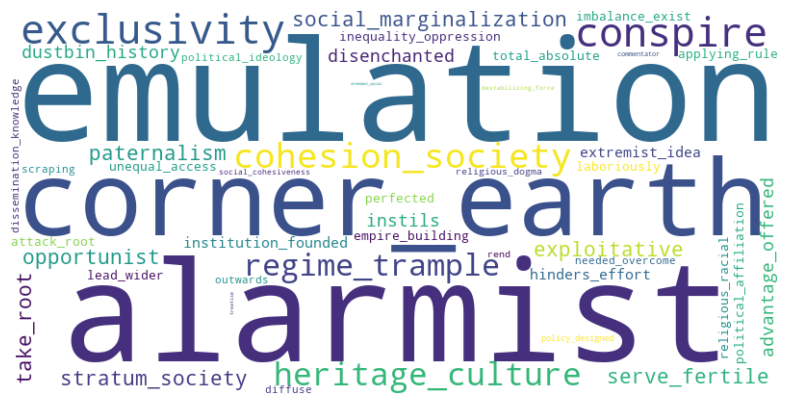

In [206]:
# Define a dictionary to hold word frequencies
word_freq = {word: len(closest) - i for i, word in enumerate(closest)}

# Create a WordCloud object with custom weights
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## For one cluster (kmeans clusters)

In [144]:
import joblib
from computing_centroids import compute_centroids
import pickle

cluster_sub_data=sub_data.loc[sub_data['cluster']==0].reset_index()

sentences = sub_data['clean_text_merged'].values
model = Word2Vec(sentences, vector_size=200, min_count=1, window=20, sg=1)
fname = f"word2vec_cluster_sub.model"
model.save(fname)

# Create an empty dictionary for word frequencies
word_freq = {}

# Count word frequencies
for sentence in sentences:
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1  # Increment count if the word is already in the dictionary
        else:
            word_freq[word] = 1  # Initialize count for new words

# Path to save the pickle file
pickle_file_path = 'wordscount_preprocess_cluster.pkl'

# Open the file in write-binary mode and save the dictionary
with open(pickle_file_path, 'wb') as f:
    pickle.dump(word_freq, f)

territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

fname = f"word2vec_cluster_sub.model"

w2v = Word2Vec.load(fname)
words_frequency = joblib.load('wordscount_preprocess_cluster.pkl')

c_territorial=compute_centroids(w2v, territorial_terms, words_frequency)
c_functional=compute_centroids(w2v, functional_terms, words_frequency)

100%|██████████| 100360/100360 [00:00<00:00, 3029132.36it/s]


In [145]:
territoriality=[]
functionality=[]
centroids=[]
for speech in cluster_sub_data['clean_text_merged'].values:
    speech_centroid= compute_centroids(w2v, speech, words_frequency)
    similarity_territorial = cosine_similarity(speech_centroid, c_territorial)
    similarity_functional= cosine_similarity(speech_centroid, c_functional)
    territoriality.append(similarity_territorial)
    functionality.append(similarity_functional)
    centroids.append(speech_centroid)

100%|██████████| 100360/100360 [00:00<00:00, 2982621.46it/s]


In [146]:
cluster_sub_data['territoriality_w2v_centroid']=territoriality
cluster_sub_data['speech_w2v_centroid']=centroids
cluster_sub_data['functionality_w2v_centroid']=functionality

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

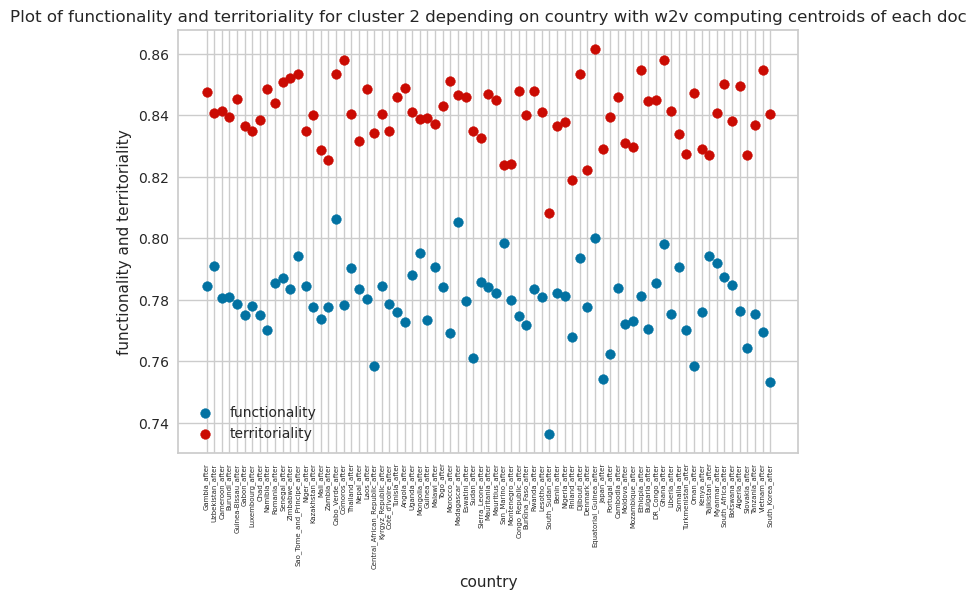

In [147]:
plt.scatter(cluster_sub_data['tag'], cluster_sub_data['functionality_w2v_centroid'], marker='o', label='functionality')
plt.scatter(cluster_sub_data['tag'], cluster_sub_data['territoriality_w2v_centroid'], marker='o', color='r', label='territoriality')

# Set the plot title
plt.title('Plot of functionality and territoriality for cluster 2 depending on country with w2v computing centroids of each doc')

plt.xticks(rotation=90, fontsize=5)

# Add labels to the axes (optional)
plt.xlabel('country')
plt.ylabel('functionality and territoriality')

plt.legend()
# Display the plot
plt.show()

In [137]:
model=w2v


territorial_seed_vectors = sum([model.wv[word] for word in territorial_terms if word in model.wv.index_to_key]) / len(territorial_terms)
functional_seed_vectors = sum([model.wv[word] for word in functional_terms if word in model.wv.index_to_key]) / len(functional_terms)

# Calculate semantic similarity between each word in the vocabulary and seed words
word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
word_similarities = {}

for word, vector in word_vectors.items():
    territorial_similarity = cosine_similarity([vector], [territorial_seed_vectors])[0][0]
    functional_similarity = cosine_similarity([vector], [functional_seed_vectors])[0][0]
    word_similarities[word] = (territorial_similarity, functional_similarity)

sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][0]), reverse=True)
top_20_words_territorial = sorted_word_similarities[:30]

top_territorial=[word for word, (func_sim, terr_sim) in top_20_words_territorial[:30]]

print("Top 30 words related to high territorial terms:", top_territorial)

Top 30 words related to high territorial terms: ['arab_spring', 'strife', 'high_price', 'religious_cultural', 'intertwined', 'axis', 'dialogue_religion', 'dependence', 'believing', 'vital_interest', 'uniting', 'loser', 'prestige', 'geographic_location', 'favourable', 'prosperous_future', 'moving_away', 'prosperity_region', 'improving_relation', 'alongside', 'swept', 'common_understanding', 'commerce', 'excellent_relation', 'forge', 'recent_month', 'contribute_establishment', 'tranquil', 'fruitful_partnership', 'broader_regional']


In [138]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][1]), reverse=True)
top_20_words_functional = sorted_word_similarities[:30]

top_functional=[word for word, (func_sim, terr_sim) in top_20_words_functional[:30]]

print("Top 30 words related to high functional terms:", top_functional)

Top 30 words related to high functional terms: ['fertile_ground', 'plague', 'breeding_ground', 'terrorist_network', 'social_condition', 'treat', 'political_socio', 'regional_war', 'zero_tolerance', 'guise', 'regression', 'combination', 'deterioration', 'employ', 'spread_extremist', 'social_harmony', 'malign', 'race_religion', 'widespread', 'european_asian', 'struggle_terrorism', 'know_border', 'poverty_lack', 'concomitant', 'fighting_poverty', 'asset', 'detriment', 'social_inequality', 'underlying_cause', 'tolerant_islamic']
